# Task 4: Mitigating Bias (Decision Tree)

In this notebook, you will train a Decision Tree model to predict the `prior_hiring_decision` target variable. You should compare its performance (Accuracy and Fairness) to the Logistic Regression baseline.

In [9]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Load Data
train_df = pd.read_csv('../data/train.csv')
val_df = pd.read_csv('../data/val.csv')
test_df = pd.read_csv('../data/test.csv')

print("Training Shape:", train_df.shape)

Training Shape: (30000, 13)


## Preprocessing Mitigation

In [ ]:
import importlib
import utils
importlib.reload(utils)
from utils import preprocess_data, compute_reweighing_weights  # since notebook is in src/, this is correct
data, clf = preprocess_data(train_df, val_df, test_df, 
                            sensitive_col='is_white', 
                            classifier=DecisionTreeClassifier(max_depth=5))
weight = compute_reweighing_weights(data['sensitive_val'], data['y_train'])
X_train = data['X_train']
y_train = data['y_train']
X_val = data['X_val']
y_val = data['y_val']
X_test = data['X_test']
y_test = data['y_test']
sensitive_val = data['sensitive_val']
sensitive_test = data['sensitive_test']

Using Features: ['Age', 'Workclass', 'Education', 'Marital_Status', 'Occupation', 'Relationship', 'Hours_Per_Week', 'Sex', 'Place_Of_Birth', 'interview_score', 'cv_assessment_score']
Numerical: ['Age', 'Hours_Per_Week', 'interview_score', 'cv_assessment_score']
Categorical: ['Workclass', 'Education', 'Marital_Status', 'Occupation', 'Relationship', 'Sex', 'Place_Of_Birth']


## Fit and validate the classifier

In [ ]:
# Train Classifier
clf.fit(X_train, y_train, classifier__sample_weight=weight)
# Validate Classifier
y_pred_val = clf.predict(X_val)
y_score_val = clf.predict_proba(X_val)[:, 1]
accuracy_val = accuracy_score(y_val, y_pred_val)
print(f'Validation Accuracy (reweight): {accuracy_val:.4f}')

Validation Accuracy (reweight): 0.7291


## Post-processing Mitigation
### Perform grid search on tau a and b in range 0.3 to 0.8
results are logged and will be used to find the best parameter later

In [ ]:

importlib.reload(utils)
from utils import post_process_mitigation, fairness_metrics, group_tpr


tau_as = np.linspace(0.3, 0.8, 50)  # initial thresholds
tau_bs = np.linspace(0.3, 0.8, 50)  # initial thresholds
TAU_A, TAU_B = np.meshgrid(tau_as, tau_bs, indexing="ij")
results = {
           "tau_as": TAU_A, "tau_bs": TAU_B, 
           "achieved_tprs": np.zeros((len(tau_as), len(tau_bs))), 
           "accuracies": np.zeros((len(tau_as), len(tau_bs))), 
           "fairness_gaps": np.zeros((len(tau_as), len(tau_bs)))}
for i, tau_a in enumerate(tau_as):
    for j, tau_b in enumerate(tau_bs):
        # Apply different thresholds for different groups
        y_pred_post_process = post_process_mitigation(y_score_val, sensitive_val, tau_a, tau_b)

        _acc_threshold = accuracy_score(y_val, y_pred_post_process)
        fairness_results, fairness_gaps = fairness_metrics(y_val, y_pred_post_process, sensitive_val)
        # print("==="*10)
        # print(f"Post-Processing | Accuracy={_acc_threshold:.4f} | Tau_a={tau_a:.4f}, Tau_b={tau_b:.4f} | delta accuracy={_acc_threshold - accuracy_val:.4f}")
        for metric, gap in fairness_gaps.items():
            print(f"{metric} Gap: {gap}")
        tpr0 = group_tpr(y_val, y_pred_post_process, sensitive_val, 0)
        tpr1 = group_tpr(y_val, y_pred_post_process, sensitive_val, 1)
        achieved = 0.5 * (tpr0 + tpr1)
        results["accuracies"][i, j] = _acc_threshold
        results["fairness_gaps"][i, j] = fairness_gaps['EO_gap_|TPR(A=1)-TPR(A=0)|']
        results["achieved_tprs"][i, j] = achieved


Post-Processing | Accuracy=0.7102 | Tau_a=0.3000, Tau_b=0.3000 | delta accuracy=-0.0189
DP_gap_|P(yhat=1|A=1)-P(yhat=1|A=0)| Gap: 0.17385891734019931
EO_gap_|TPR(A=1)-TPR(A=0)| Gap: 0.07638014741886623
FPR_gap_|FPR(A=1)-FPR(A=0)| Gap: 0.14726718640114933
EOD_gap_max(TPR_gap,FPR_gap) Gap: 0.14726718640114933
Post-Processing | Accuracy=0.7102 | Tau_a=0.3000, Tau_b=0.3102 | delta accuracy=-0.0189
DP_gap_|P(yhat=1|A=1)-P(yhat=1|A=0)| Gap: 0.17385891734019931
EO_gap_|TPR(A=1)-TPR(A=0)| Gap: 0.07638014741886623
FPR_gap_|FPR(A=1)-FPR(A=0)| Gap: 0.14726718640114933
EOD_gap_max(TPR_gap,FPR_gap) Gap: 0.14726718640114933
Post-Processing | Accuracy=0.7124 | Tau_a=0.3000, Tau_b=0.3204 | delta accuracy=-0.0167
DP_gap_|P(yhat=1|A=1)-P(yhat=1|A=0)| Gap: 0.14599216525820058
EO_gap_|TPR(A=1)-TPR(A=0)| Gap: 0.05351612816495532
FPR_gap_|FPR(A=1)-FPR(A=0)| Gap: 0.11370554256553284
EOD_gap_max(TPR_gap,FPR_gap) Gap: 0.11370554256553284
Post-Processing | Accuracy=0.7124 | Tau_a=0.3000, Tau_b=0.3306 | delta ac

### Get the best accuracy of fairness metric under a certain value

In [13]:
# Find best accuracy under EO gap < Metric_threshold
Metric_threshold = 0.05
rows, cols = np.where(results['fairness_gaps'] < Metric_threshold)
filtered_accuracies = results['accuracies'][rows, cols]
best_accuracy_idx = np.argmax(filtered_accuracies)
best_k = np.argmax(filtered_accuracies)
i_best = rows[best_k]
j_best = cols[best_k]
fairness_metric_value = results['fairness_gaps'][i_best, j_best]
best_accuracy = filtered_accuracies[best_k]
tau_a_best = tau_as[i_best]
tau_b_best = tau_bs[j_best]
print(f'Tau_a={tau_a_best:.4f}, Tau_b={tau_b_best:.4f} achieve Accuracy={best_accuracy:.4f} under EO gap<{Metric_threshold}')

Tau_a=0.4122, Tau_b=0.4837 achieve Accuracy=0.7294 under EO gap<0.05


# Results
## Validation Results

In [ ]:
EO_reweighted = fairness_metrics(y_val, y_pred_val, sensitive_val)[1]['EO_gap_|TPR(A=1)-TPR(A=0)|']
print(f"Validation Set | Accuracy(reweight)={accuracy_val:.4f} | Accuracy(threshold)={best_accuracy:.4f}")
print(f"EO(reweighted): {EO_reweighted:.4f} | EO(threshold): {fairness_metric_value:.4f} ")

Validation Set | Accuracy(reweight)=0.7291 | Accuracy(threshold)=0.7294
EO(reweighted): 0.1808 | EO(threshold): 0.0101 


## Test Results

In [ ]:
y_pred_test = clf.predict(X_test)
y_score_test = clf.predict_proba(X_test)[:, 1]

y_pred_test_threshold = post_process_mitigation(y_score_test, sensitive_test, tau_a_best, tau_b_best)
acc_test_threshold = accuracy_score(y_test, y_pred_test_threshold)
acc_test = accuracy_score(y_test, y_pred_test)
_, fairness_gaps_test_post = fairness_metrics(y_test, y_pred_test_threshold, sensitive_test)
_, fairness_gaps_test = fairness_metrics(y_test, y_pred_test, sensitive_test)
print(f"Test Set | Accuracy(reweight)={acc_test:.4f} | Accuracy(threshold)={acc_test_threshold:.4f}")
print(f"EO(reweight)={fairness_gaps_test['EO_gap_|TPR(A=1)-TPR(A=0)|']:.4f} | EO(threshold)={fairness_gaps_test_post['EO_gap_|TPR(A=1)-TPR(A=0)|']:.4f} ")

Test Set | Accuracy(reweight)=0.7283 | Accuracy(threshold)=0.7233
EO(reweight)=0.1700 | EO(threshold)=0.0077 


## Get plots on Test Set
The following code will plot three graphs
#### Accuracy Heatmap Over (tau a, tau b)
The Accuracy Heat map shows that, for a large zone of tau a and tau b (yellow) the validation accuracy is high.
#### Fairness Heatmap Over (tau a, tau b)
Since the lowest EO diff the better, we are looking for darker zone. We can see there are some areas that the darker zone in fairness heatmap overlaps with the yellow zone in accuracy heatmap. This overlapping area is the sweet point - we can get high accuracy with low EO difference.
#### ROC curve
AUC=0.80 as plotted on ROC curve.

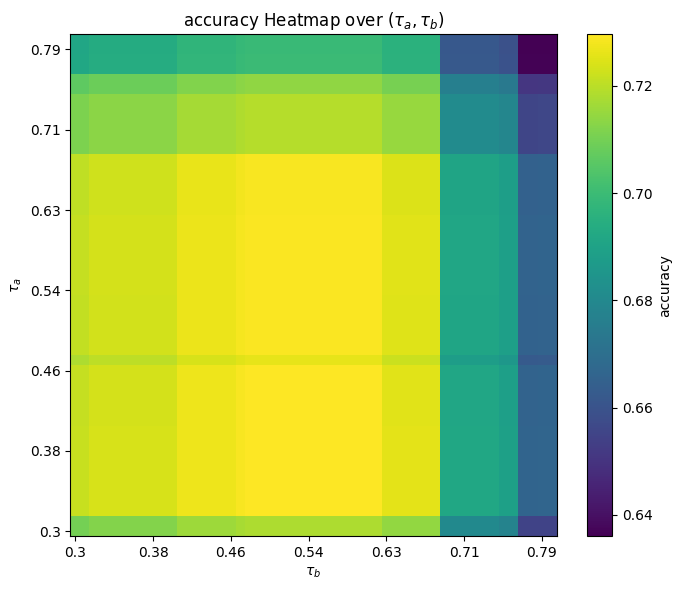

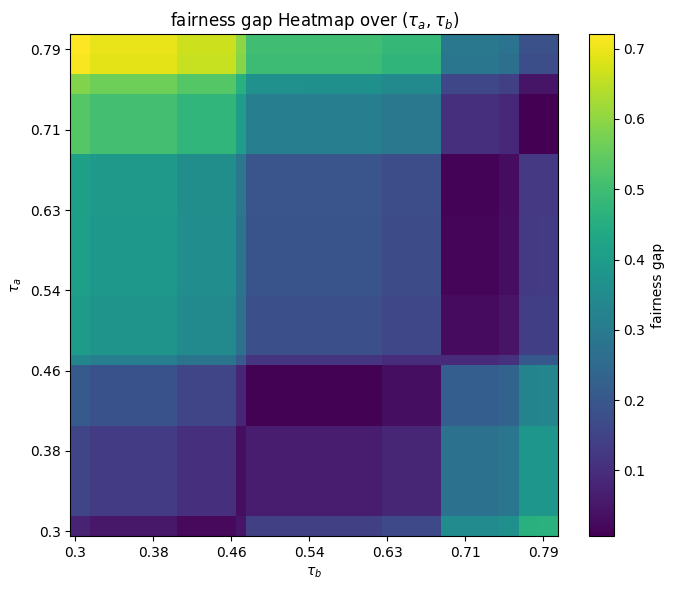

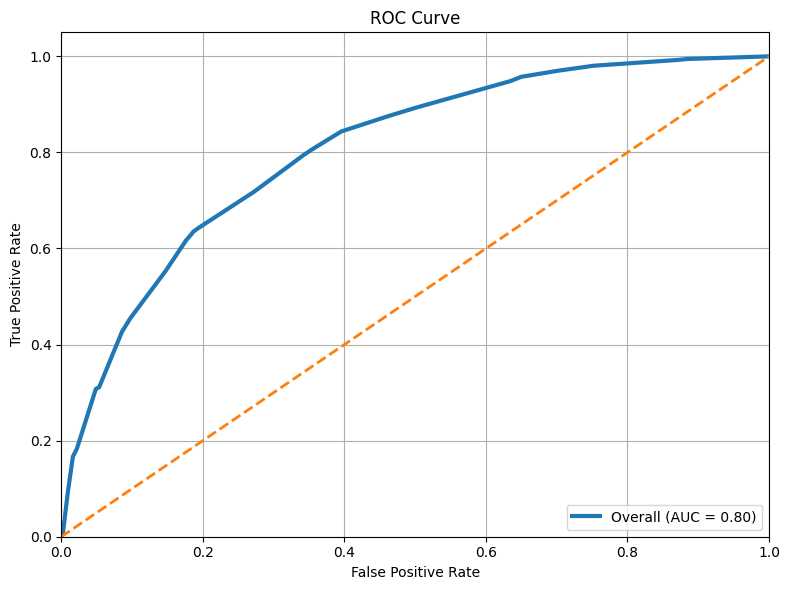

In [ ]:
importlib.reload(utils)
from utils import plot_roc_curve, plot_attribute_on_thresholds

plot_attribute_on_thresholds(tau_as, tau_bs, results["accuracies"], "accuracy")
plot_attribute_on_thresholds(tau_as, tau_bs, results["fairness_gaps"], "fairness gap")
plot_roc_curve(y_test, y_score_test)